In [2]:
import numpy as np
import networkx as nx
from pyvis import network as net
import random
import time

# Zadanie 3

In [3]:
def load_graph_from_file(dir_path = "./graphs/example1/"):
    edges = list(map(lambda x: list(map(lambda y: float(y), x.strip().split())), open(dir_path + "edges.txt", "r").readlines()))
    sources = list(map(lambda x: list(map(lambda y: float(y), x.strip().split())), open(dir_path + "sources.txt", "r").readlines()))

    H = nx.Graph()
    nodes = set()
    resistance_dict = {}
    sources_dict = {}
    edge_indeces_dict = {}
    node_indeces_dict = {}

    for u, v, R in edges:
        nodes.add(int(u))
        nodes.add(int(v))

    nodes = list(nodes)

    for u, v, E in sources:
        u, v = int(u), int(v)
        sources_dict[(u, v)] = E

    for i in range(len(nodes)):
        H.add_node(nodes[i], label = str(nodes[i]))
        node_indeces_dict[nodes[i]] = i

    for i in range(len(edges)):
        u, v, R = edges[i]
        u, v = int(u), int(v)
        resistance_dict[(u, v)] = R
        edge_indeces_dict[(u, v)] = i

        H.add_edge(u, v, label = round(R, 2))

    return H, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict

In [4]:
def init_graph(G, res_low = 10, res_high = 20, num_sources = 5, sources_low = 5, sources_high = 15):
    H = nx.Graph()
    edges = list(G.edges)
    nodes = list(G.nodes)
    resistance_dict = {}
    sources_dict = {}
    edge_indeces_dict = {}
    node_indeces_dict = {}
    
    for i in range(len(nodes)):
        H.add_node(nodes[i], label = str(nodes[i]))
        node_indeces_dict[nodes[i]] = i

    for i in range(len(edges)):
        u, v = edges[i]
        R = np.random.uniform(res_low, res_high)
        resistance_dict[(u, v)] = R
        edge_indeces_dict[(u, v)] = i
        
        H.add_edge(u, v, label = round(R, 2))

    for u, v in random.sample(list(G.edges), num_sources):
        sources_dict[(u, v)] = np.random.uniform(sources_low, sources_high)

    return H, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict


In [5]:
def solve_circuit(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict):

    cycles = nx.cycle_basis(G)

    coefficients = np.zeros(shape = (len(cycles) + len(G.nodes), len(G.edges)))

    constants = np.zeros(shape = len(cycles) + len(G.nodes))

    for i in range(len(cycles)):
        for j in range(len(cycles[i])):
            u, v = cycles[i][j], cycles[i][(j + 1) % len(cycles[i])]

            if (u, v) in edge_indeces_dict:

                k = edge_indeces_dict[(u, v)]
                
                coefficients[i][k] -= resistance_dict[(u, v)]
                
                if (u, v) in sources_dict:
                    constants[i] -= resistance_dict[(u, v)]

            elif (v, u) in edge_indeces_dict:

                k = edge_indeces_dict[(v, u)]

                coefficients[i][k] += resistance_dict[(v, u)]

                if (v, u) in sources_dict:
                    constants[i] += sources_dict[(v, u)]

    for u in node_indeces_dict:
        for v in G[u]:
            if (u, v) in edge_indeces_dict:
                k = edge_indeces_dict[(u, v)]

                coefficients[len(cycles) + node_indeces_dict[u]][k] = -1


            elif (v, u) in edge_indeces_dict:
                k = edge_indeces_dict[(v, u)]

                coefficients[len(cycles) + node_indeces_dict[u]][k] = 1

    X = np.linalg.lstsq(coefficients, constants)

    return G, edge_indeces_dict, X[0]


In [17]:
def solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict):

    cycles = nx.cycle_basis(G)

    coefficients = np.zeros(shape = (len(G.edges), len(G.edges)))

    constants = np.zeros(shape = len(G.edges))

    for i in range(len(cycles)):
        for j in range(len(cycles[i])):
            u, v = cycles[i][j], cycles[i][(j + 1) % len(cycles[i])]

            if (u, v) in edge_indeces_dict:

                k = edge_indeces_dict[(u, v)]
                
                coefficients[i][k] -= resistance_dict[(u, v)]
                
                if (u, v) in sources_dict:
                    constants[i] -= resistance_dict[(u, v)]

            elif (v, u) in edge_indeces_dict:

                k = edge_indeces_dict[(v, u)]

                coefficients[i][k] += resistance_dict[(v, u)]

                if (v, u) in sources_dict:
                    constants[i] += sources_dict[(v, u)]

    nodes = list(node_indeces_dict.keys())

    for i in range(len(nodes) - 1):
        u = nodes[i]
        for v in G[u]:
            if (u, v) in edge_indeces_dict:
                k = edge_indeces_dict[(u, v)]

                coefficients[len(cycles) + node_indeces_dict[u]][k] = -1


            elif (v, u) in edge_indeces_dict:
                k = edge_indeces_dict[(v, u)]

                coefficients[len(cycles) + node_indeces_dict[u]][k] = 1

    X = np.linalg.solve(coefficients, constants)

    return G, edge_indeces_dict, X

In [6]:
def percentage(low, high, value):
    if low == high:
        return 0
    else:
        return (value - low) / (high - low)

In [7]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [8]:
def vis_solved_circuit(G, X, edge_indeces_dict, resistance_dict, sources_dict):
    H = nx.DiGraph()

    I_high = max(abs(X))
    I_low = min(abs(X))

    for u in G.nodes:
        H.add_node(str(u), label = str(u))

    for u, v in G.edges:
        
        p = percentage(I_low, I_high, abs(X[edge_indeces_dict[(u, v)]]))

        r = int(p * 255)
        g = int((1 - p) * 255)
        b = 0

        color = rgb_to_hex((r, g, b))

        if X[edge_indeces_dict[(u, v)]] >= 0:
            if (u, v) in sources_dict:
                label = "R = {R}, I = {I}, U = {U}".format(R = round(resistance_dict[(u, v)], 2), I = round(X[edge_indeces_dict[(u, v)]], 2), U = round(sources_dict[(u, v)], 2))
            else:
                label = "R = {R}, I = {I}".format(R = round(resistance_dict[(u, v)], 2), I = round(X[edge_indeces_dict[(u, v)]], 2))

            H.add_edge(str(u), str(v), label = label, color = color)

        else:
            if (u, v) in sources_dict:
                label = "R = {R}, I = {I}, U = {U}".format(R = round(resistance_dict[(u, v)], 2), I = -round(X[edge_indeces_dict[(u, v)]], 2), U = round(sources_dict[(u, v)], 2))
            else:
                label = "R = {R}, I = {I}".format(R = round(resistance_dict[(u, v)], 2), I = -round(X[edge_indeces_dict[(u, v)]], 2))

            H.add_edge(str(v), str(u), label = label, color = color)

    vis = net.Network(notebook = True, cdn_resources = "in_line", directed = True)

    vis.from_nx(H)

    return vis

In [9]:
def test_validity(G, edge_indices_dict, X, eps = 10e-6):
    for u in G:
        result = 0
        for v in G[u]:

            if (u, v) in edge_indices_dict:
                result += X[edge_indices_dict[(u, v)]]
            
            elif (v, u) in edge_indices_dict:
                result -= X[edge_indices_dict[(v, u)]]

        if abs(result) > eps:
            return False
    return True

# Examples

After running each cell vis.html file is updated with new visualization, but it cannot be shown directly in the notebook. To see the results open file vis.html or click <a href = "http://localhost:3000/lab2/vis.html">here</a>

In [34]:
n = 12
p = 0.25

erdos_renyi_graph = nx.erdos_renyi_graph(n, p)
G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict = init_graph(erdos_renyi_graph)
H, edge_indeces_dict, X  = solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict)

vis = vis_solved_circuit(H, X, edge_indeces_dict, resistance_dict, sources_dict)

vis.show("vis.html")

print("Test passed: {passed}".format(passed = test_validity(H, edge_indeces_dict, X)))

Test passed: True


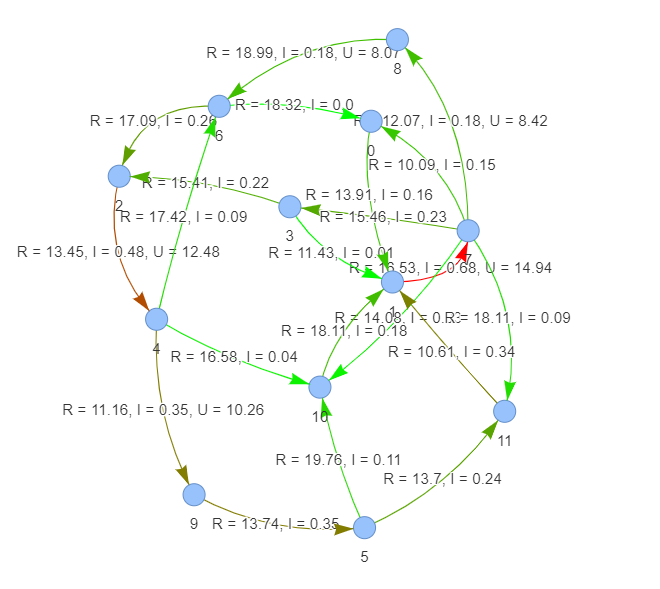

In [22]:
cubical_graph = nx.cubical_graph()

G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict = init_graph(cubical_graph)
H, edge_indeces_dict, X  = solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict)

vis = vis_solved_circuit(H, X, edge_indeces_dict, resistance_dict, sources_dict)

vis.show("vis.html")

print("Test passed: {passed}".format(passed = test_validity(H, edge_indeces_dict, X)))

Test passed: True


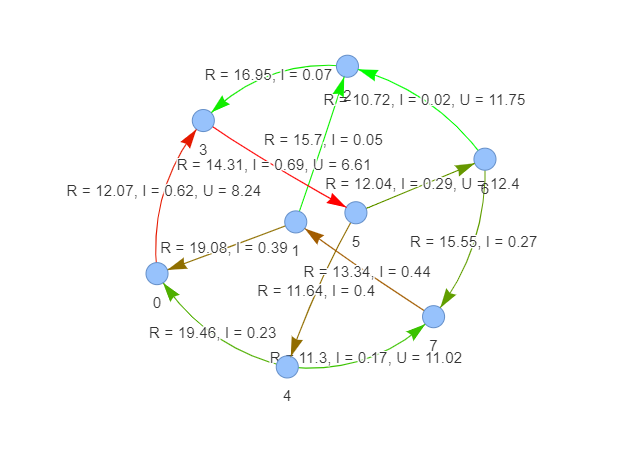

In [21]:
m = 6
n = 5

grid_2d_graph = nx.grid_2d_graph(m, n)
G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict = init_graph(grid_2d_graph)
H, edge_indeces_dict, X  = solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict)

vis = vis_solved_circuit(H, X, edge_indeces_dict, resistance_dict, sources_dict)

vis.show("vis.html")

print("Test passed: {passed}".format(passed = test_validity(H, edge_indeces_dict, X)))

Test passed: True


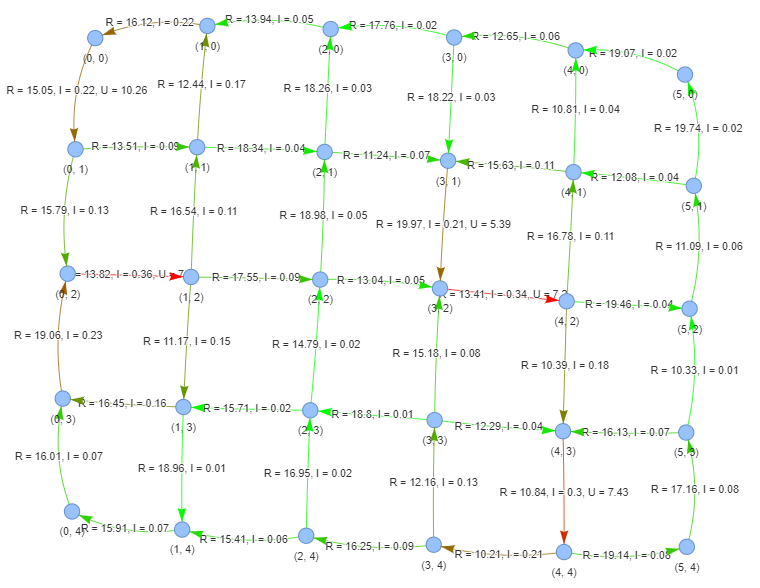

In [20]:
n = 6

small_world_graph = nx.navigable_small_world_graph(n)
small_world_graph.remove_edges_from(nx.selfloop_edges(small_world_graph))
small_world_graph = small_world_graph.to_undirected()

G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict = init_graph(small_world_graph)
H, edge_indeces_dict, X  = solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict)

vis = vis_solved_circuit(H, X, edge_indeces_dict, resistance_dict, sources_dict)

vis.show("vis.html")

print("Test passed: {passed}".format(passed = test_validity(H, edge_indeces_dict, X)))

Test passed: True


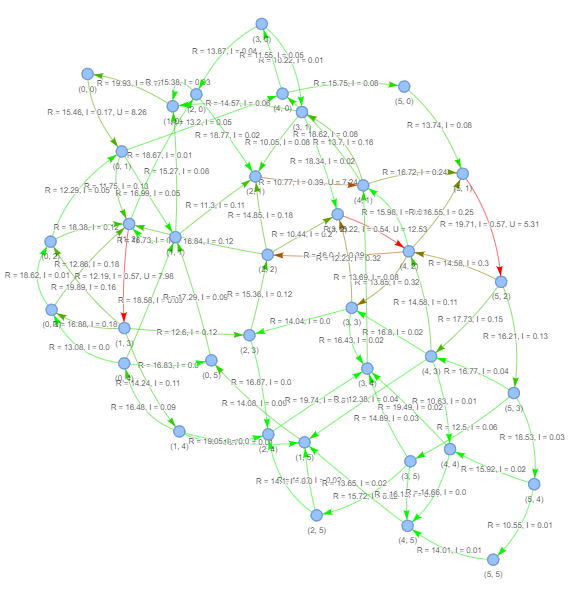

In [19]:
a = nx.erdos_renyi_graph(12, 0.4)
b = nx.erdos_renyi_graph(10, 0.4)

c = nx.union(a, b, rename = ('a-', 'b-'))
R = np.random.uniform(low = 5, high = 15)

c.add_edge('a-0', 'b-0')
c.add_edge('a-1', 'b-1')

G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict = init_graph(c)
H, edge_indeces_dict, X  = solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict)

vis = vis_solved_circuit(H, X, edge_indeces_dict, resistance_dict, sources_dict)

vis.show("vis.html")

print("Test passed: {passed}".format(passed = test_validity(G, edge_indeces_dict, X)))

Test passed: True


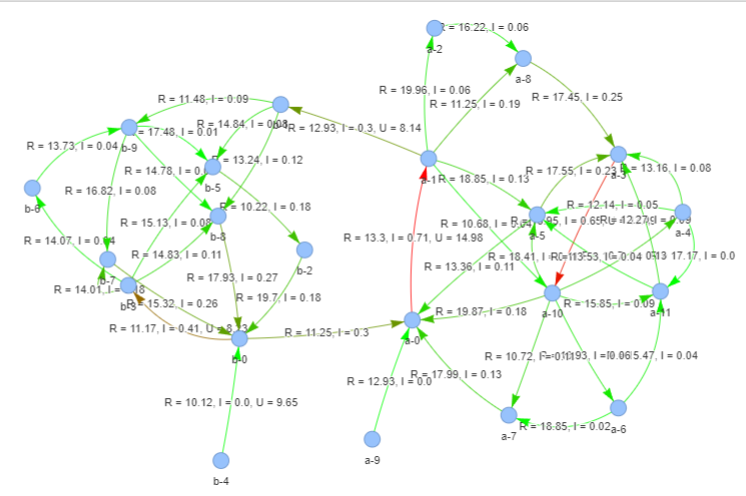

In [18]:
G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict = load_graph_from_file()
H, edge_indeces_dict, X  = solve_circuit_fitted(G, sources_dict, resistance_dict, edge_indeces_dict, node_indeces_dict)

vis = vis_solved_circuit(H, X, edge_indeces_dict, resistance_dict, sources_dict)

vis.show("vis.html")

print("Test passed: {passed}".format(passed = test_validity(H, edge_indeces_dict, X)))

Test passed: True


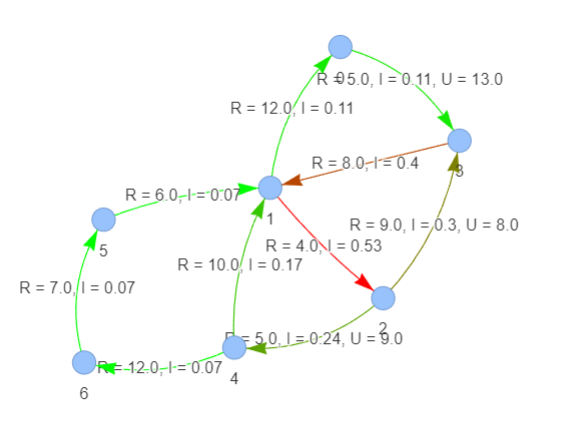

# Benchmarks

### Erdos Renyi Graph

In [24]:
dim_min = 20
dim_step = 10
tests_number = 10
p = 0.4

for i in range(tests_number):
    n = dim_min + i * dim_step
    print("Test {i}".format(i = i))
    
    erdos_renyi_graph = nx.erdos_renyi_graph(n, p)

    G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1 = init_graph(erdos_renyi_graph)
    G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2 = init_graph(erdos_renyi_graph)
    
    time_stamp1 = time.time()

    H1, edge_indeces_dict1, X1  = solve_circuit(G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1)

    time_stamp2 = time.time()

    H2, edge_indeces_dict2, X2 = solve_circuit_fitted(G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2)

    time_stamp3 = time.time()

    print("V = {V}, E = {E}".format(V = len(G1.nodes), E = len(G1.edges)))
    
    print("np.linalg.lstsq:")
    if test_validity(H1, edge_indeces_dict1, X1):
        print("Passed :). Time: {time}".format(time = time_stamp2 - time_stamp1))
    else:
        print("Failed :(")

    print("np.linalg.solve:")
    if test_validity(H2, edge_indeces_dict2, X2):
        print("Passed :). Time: {time}".format(time = time_stamp3 - time_stamp2))
    else:
        print("Failed :(")

Test 0
V = 20, E = 66
np.linalg.lstsq:
Passed :). Time: 0.005991935729980469
np.linalg.solve:
Passed :). Time: 0.0029973983764648438
Test 1
V = 30, E = 173
np.linalg.lstsq:
Passed :). Time: 0.012988567352294922
np.linalg.solve:
Passed :). Time: 0.016000032424926758
Test 2
V = 40, E = 318
np.linalg.lstsq:
Passed :). Time: 0.047522783279418945
np.linalg.solve:
Passed :). Time: 0.007006406784057617
Test 3


C:\Users\mateu\AppData\Local\Temp\ipykernel_11584\1202000023.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(coefficients, constants)


V = 50, E = 491
np.linalg.lstsq:
Passed :). Time: 0.18245244026184082
np.linalg.solve:
Passed :). Time: 0.017241239547729492
Test 4
V = 60, E = 706
np.linalg.lstsq:
Passed :). Time: 0.19396758079528809
np.linalg.solve:
Passed :). Time: 0.037999629974365234
Test 5
V = 70, E = 990
np.linalg.lstsq:
Passed :). Time: 0.5241146087646484
np.linalg.solve:
Passed :). Time: 0.03400135040283203
Test 6
V = 80, E = 1258
np.linalg.lstsq:
Passed :). Time: 1.4351749420166016
np.linalg.solve:
Passed :). Time: 0.10254073143005371
Test 7
V = 90, E = 1582
np.linalg.lstsq:
Passed :). Time: 2.728121757507324
np.linalg.solve:
Passed :). Time: 0.13499879837036133
Test 8
V = 100, E = 1977
np.linalg.lstsq:
Passed :). Time: 5.315036773681641
np.linalg.solve:
Passed :). Time: 0.24500060081481934
Test 9
V = 110, E = 2404
np.linalg.lstsq:
Passed :). Time: 10.978509902954102
np.linalg.solve:
Passed :). Time: 0.4070014953613281


### Cubical graph

In [25]:
tests_number = 5

for i in range(tests_number):
    n = dim_min + i * dim_step
    print("Test {i}".format(i = i))

    cubical_graph = nx.cubical_graph()

    G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1 = init_graph(cubical_graph)
    G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2 = init_graph(cubical_graph)
    
    time_stamp1 = time.time()

    H1, edge_indeces_dict1, X1  = solve_circuit(G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1)

    time_stamp2 = time.time()

    H2, edge_indeces_dict2, X2 = solve_circuit_fitted(G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2)

    time_stamp3 = time.time()

    print("V = {V}, E = {E}".format(V = len(G1.nodes), E = len(G1.edges)))
    
    print("np.linalg.lstsq:")
    if test_validity(H1, edge_indeces_dict1, X1):
        print("Passed :). Time: {time}".format(time = time_stamp2 - time_stamp1))
    else:
        print("Failed :(")

    print("np.linalg.solve:")
    if test_validity(H2, edge_indeces_dict2, X2):
        print("Passed :). Time: {time}".format(time = time_stamp3 - time_stamp2))
    else:
        print("Failed :(")

Test 0
V = 8, E = 12
np.linalg.lstsq:
Passed :). Time: 0.0009982585906982422
np.linalg.solve:
Passed :). Time: 0.0
Test 1
V = 8, E = 12
np.linalg.lstsq:
Passed :). Time: 0.0
np.linalg.solve:
Passed :). Time: 0.0010004043579101562
Test 2
V = 8, E = 12
np.linalg.lstsq:
Passed :). Time: 0.0010063648223876953
np.linalg.solve:
Passed :). Time: 0.0
Test 3
V = 8, E = 12
np.linalg.lstsq:
Passed :). Time: 0.0
np.linalg.solve:
Passed :). Time: 0.0010020732879638672
Test 4
V = 8, E = 12
np.linalg.lstsq:
Passed :). Time: 0.0
np.linalg.solve:
Passed :). Time: 0.0


C:\Users\mateu\AppData\Local\Temp\ipykernel_11584\1202000023.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(coefficients, constants)


### Grid 2D graph

In [31]:
dim1_min = 10
dim1_step = 4
dim2_min = 15
dim2_step = 5
tests_number = 10

for i in range(tests_number):
    n = dim1_min + i * dim1_step
    m = dim2_min + i * dim2_step

    print("Test {i}".format(i = i))

    grid_2d_graph = nx.grid_2d_graph(n, m)

    G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1 = init_graph(grid_2d_graph)
    G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2 = init_graph(grid_2d_graph)
    
    time_stamp1 = time.time()

    H1, edge_indeces_dict1, X1  = solve_circuit(G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1)

    time_stamp2 = time.time()

    H2, edge_indeces_dict2, X2 = solve_circuit_fitted(G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2)

    time_stamp3 = time.time()

    print("V = {V}, E = {E}".format(V = len(G1.nodes), E = len(G1.edges)))
    
    print("np.linalg.lstsq:")
    if test_validity(H1, edge_indeces_dict1, X1):
        print("Passed :). Time: {time}".format(time = time_stamp2 - time_stamp1))
    else:
        print("Failed :(")

    print("np.linalg.solve:")
    if test_validity(H2, edge_indeces_dict2, X2):
        print("Passed :). Time: {time}".format(time = time_stamp3 - time_stamp2))
    else:
        print("Failed :(")

Test 0
V = 150, E = 275
np.linalg.lstsq:
Passed :). Time: 0.026000499725341797
np.linalg.solve:
Passed :). Time: 0.01600337028503418
Test 1


C:\Users\mateu\AppData\Local\Temp\ipykernel_11584\1202000023.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(coefficients, constants)


V = 280, E = 526
np.linalg.lstsq:
Passed :). Time: 0.11200141906738281
np.linalg.solve:
Passed :). Time: 0.08800244331359863
Test 2
V = 450, E = 857
np.linalg.lstsq:
Passed :). Time: 0.8249039649963379
np.linalg.solve:
Passed :). Time: 0.0961148738861084
Test 3
V = 660, E = 1268
np.linalg.lstsq:
Passed :). Time: 2.2611424922943115
np.linalg.solve:
Passed :). Time: 0.09271717071533203
Test 4
V = 910, E = 1759
np.linalg.lstsq:
Passed :). Time: 4.446535348892212
np.linalg.solve:
Passed :). Time: 0.1759934425354004
Test 5
V = 1200, E = 2330
np.linalg.lstsq:
Passed :). Time: 9.04730486869812
np.linalg.solve:
Passed :). Time: 0.38899660110473633
Test 6
V = 1530, E = 2981
np.linalg.lstsq:
Passed :). Time: 19.715020895004272
np.linalg.solve:
Passed :). Time: 0.7701547145843506
Test 7
V = 1900, E = 3712
np.linalg.lstsq:
Passed :). Time: 32.98813796043396
np.linalg.solve:
Passed :). Time: 0.8790040016174316
Test 8
V = 2310, E = 4523
np.linalg.lstsq:
Passed :). Time: 39.580761432647705
np.linalg.

### Small world graph

In [27]:
dim_min = 3
dim_step = 3
tests_number = 10

for i in range(tests_number):
    n = dim_min + i * dim_step
    print("Test {i}".format(i = i))

    small_world_graph = nx.navigable_small_world_graph(n)
    small_world_graph.remove_edges_from(nx.selfloop_edges(small_world_graph))
    small_world_graph = small_world_graph.to_undirected()

    G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1 = init_graph(small_world_graph)
    G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2 = init_graph(small_world_graph)
    
    time_stamp1 = time.time()

    H1, edge_indeces_dict1, X1  = solve_circuit(G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1)

    time_stamp2 = time.time()

    H2, edge_indeces_dict2, X2 = solve_circuit_fitted(G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2)

    time_stamp3 = time.time()

    print("V = {V}, E = {E}".format(V = len(G1.nodes), E = len(G1.edges)))
    
    print("np.linalg.lstsq:")
    if test_validity(H1, edge_indeces_dict1, X1):
        print("Passed :). Time: {time}".format(time = time_stamp2 - time_stamp1))
    else:
        print("Failed :(")

    print("np.linalg.solve:")
    if test_validity(H2, edge_indeces_dict2, X2):
        print("Passed :). Time: {time}".format(time = time_stamp3 - time_stamp2))
    else:
        print("Failed :(")

Test 0
V = 9, E = 12
np.linalg.lstsq:
Passed :). Time: 0.0
np.linalg.solve:
Passed :). Time: 0.0
Test 1
V = 36, E = 77
np.linalg.lstsq:
Passed :). Time: 0.0020008087158203125
np.linalg.solve:
Passed :). Time: 0.0009970664978027344
Test 2
V = 81, E = 186
np.linalg.lstsq:
Passed :). Time: 0.007999658584594727
np.linalg.solve:
Passed :). Time: 0.004014253616333008
Test 3
V = 144, E = 353
np.linalg.lstsq:
Passed :). Time: 0.026010751724243164
np.linalg.solve:
Passed :). Time: 0.02502608299255371
Test 4


C:\Users\mateu\AppData\Local\Temp\ipykernel_11584\1202000023.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(coefficients, constants)


V = 225, E = 577
np.linalg.lstsq:
Passed :). Time: 0.24709129333496094
np.linalg.solve:
Passed :). Time: 0.04197883605957031
Test 5
V = 324, E = 834
np.linalg.lstsq:
Passed :). Time: 0.3426792621612549
np.linalg.solve:
Passed :). Time: 0.07399559020996094
Test 6
V = 441, E = 1135
np.linalg.lstsq:
Passed :). Time: 1.031667709350586
np.linalg.solve:
Passed :). Time: 0.13653969764709473
Test 7
V = 576, E = 1500
np.linalg.lstsq:
Passed :). Time: 2.7374167442321777
np.linalg.solve:
Passed :). Time: 0.2630021572113037
Test 8
V = 729, E = 1898
np.linalg.lstsq:
Passed :). Time: 5.272669792175293
np.linalg.solve:
Passed :). Time: 0.28505659103393555
Test 9
V = 900, E = 2381
np.linalg.lstsq:
Passed :). Time: 11.501752614974976
np.linalg.solve:
Passed :). Time: 0.5041818618774414


### Bridge graph

In [30]:
dim1_min = 10
dim1_step = 5
p1 = 0.4
dim2_min = 12
dim2_step = 8
p2 = 0.5
tests_number = 10

for i in range(tests_number):
    n1 = dim1_min + i * dim1_step
    n2 = dim2_min + i * dim2_step

    print("Test {i}".format(i = i))

    a = nx.erdos_renyi_graph(n1, p1)
    b = nx.erdos_renyi_graph(n2, p2)

    c = nx.union(a, b, rename = ('a-', 'b-'))
    R = np.random.uniform(low = 5, high = 15)

    c.add_edge('a-0', 'b-0')
    c.add_edge('a-1', 'b-1')

    G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1 = init_graph(c)
    G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2 = init_graph(c)
    
    time_stamp1 = time.time()

    H1, edge_indeces_dict1, X1  = solve_circuit(G1, sources_dict1, resistance_dict1, edge_indeces_dict1, node_indeces_dict1)

    time_stamp2 = time.time()

    H2, edge_indeces_dict2, X2 = solve_circuit_fitted(G2, sources_dict2, resistance_dict2, edge_indeces_dict2, node_indeces_dict2)

    time_stamp3 = time.time()

    print("V = {V}, E = {E}".format(V = len(G1.nodes), E = len(G1.edges)))
    
    print("np.linalg.lstsq:")
    if test_validity(H1, edge_indeces_dict1, X1):
        print("Passed :). Time: {time}".format(time = time_stamp2 - time_stamp1))
    else:
        print("Failed :(")

    print("np.linalg.solve:")
    if test_validity(H2, edge_indeces_dict2, X2):
        print("Passed :). Time: {time}".format(time = time_stamp3 - time_stamp2))
    else:
        print("Failed :(")

Test 0
V = 22, E = 58
np.linalg.lstsq:
Passed :). Time: 0.0030066967010498047
np.linalg.solve:
Passed :). Time: 0.0009953975677490234
Test 1
V = 35, E = 137
np.linalg.lstsq:
Passed :). Time: 0.004998207092285156
np.linalg.solve:
Passed :). Time: 0.0019996166229248047
Test 2
V = 48, E = 274
np.linalg.lstsq:
Passed :). Time: 0.013999700546264648
np.linalg.solve:
Passed :). Time: 0.0020020008087158203
Test 3
V = 61, E = 419
np.linalg.lstsq:
Passed :). Time: 0.037004709243774414
np.linalg.solve:
Passed :). Time: 0.010997533798217773
Test 4


C:\Users\mateu\AppData\Local\Temp\ipykernel_11584\1202000023.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(coefficients, constants)


V = 74, E = 648
np.linalg.lstsq:
Passed :). Time: 0.27854156494140625
np.linalg.solve:
Passed :). Time: 0.03700423240661621
Test 5
V = 87, E = 874
np.linalg.lstsq:
Passed :). Time: 0.573998212814331
np.linalg.solve:
Passed :). Time: 0.04599738121032715
Test 6
V = 100, E = 1175
np.linalg.lstsq:
Passed :). Time: 1.354050636291504
np.linalg.solve:
Passed :). Time: 0.10108351707458496
Test 7
V = 113, E = 1523
np.linalg.lstsq:
Passed :). Time: 3.166177749633789
np.linalg.solve:
Passed :). Time: 0.17599797248840332
Test 8
V = 126, E = 1907
np.linalg.lstsq:
Passed :). Time: 7.045011043548584
np.linalg.solve:
Passed :). Time: 0.24995899200439453
Test 9
V = 139, E = 2312
np.linalg.lstsq:
Passed :). Time: 10.37071180343628
np.linalg.solve:
Passed :). Time: 0.32679200172424316


# Komentarz

Choć powszechnie stosowana metoda rozwiązywania obwodów elektrycznych to metoda potencjałów węzłowych, w celu lepszego zapoznania się z tematyką laboratorium (metody rozwiązywania układów równań, także nadokreślonych) wybrana została metoda oparta na I oraz II prawie Kirchoffa. W związku z tym, układ równań otrzymany z rozważenia wszystkich cykli występujących w obwodzie (II prawo Kirchoffa) oraz algebraicznych sum prądów wpływających do poszczególnych wierzchołków (I prawo Kirchoffa) jest potencjalnie nadokreślony. Ponieważ jednak I prawo Kirchoffa dostarcza nam dokładnie $V - 1$ (gdzie V - liczba wierzchołków, E - liczba krawędzi) niezależnych równań (równanie dla ostatniego wierzchołka jest liniowo zależne od pozostałych, nie ma więc sensu się nim zajmować), a II prawo Kirchoffa dostarcza nam dokładnie $E - (V - 1)$ (o ile obwód jest rozwiązywalny), to sumarycznie otrzymujemy $V - 1 + E - (V - 1) = E$ równań, czyli dokładnie tyle ile mamy zmiennych. Ostatecznie, po odrzuceniu jednego nadmiarowego (jednocześnie niepotrzebnego jako kombinacja liniowa pozostałych) równania, otrzymujemy układ $E$ równań dla $E$ zmiennych, który rozwiązujemy standardową metodą (np. z wykorzystaniem funkcji <a href = "https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html">numpy.linalg.solve</a>)

Alternatywnie można skorzystać z innej metody rozwiązywania układu równań, która pozwala także na rozwiązywanie układów nadokreślonych. Przykładowo, rozwiązanie układu równań można uzyskać z pomocą metody najmniejszych kwadratów (np. funkcja <a href = "https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html">numpy.linalg.lstsq</a>). W rzeczywistości metoda najmniejszych kwadratów daje nam najlepsze przybliżenie rozwiązań, natomiast w rozważanym problemie nadmiarowe równanie jest zależne od innych i nic nie wnosi do układu równań, co gwarantuje nam poprawne wyniki. 

W celu porównaniu obu podejść, zostały stworzone dwie funkcje:

- ```solve_circuit_fitted```, która pomija jedno nadmiarowe równanie wynikające z I prawa Kirchoffa i wykorzystuje standardową metodę rozwiązywania układu równań z pomocą funkcji ```numpy.linalg.solve()```
- ```solve_circuit```, która rozwiązuje układ nadokreślony ($E + 1$ równań) z wykorzystaniem funkcji ```numpy.linalg.lstsq```

W celu sprawdzenia efektywności obu rozwiązań, zmierzone zostały czasy wykonania dla poszczególnych funkcji (rozmiary grafów pozostały niezmienione). Analiza wyników jednoznacznie wykazuje, że użycie funkcji numpy.linalg.solve() działa znacznie szybciej niż zastosowanie metody najmniejszych kwadratów.

Ponieważ kierunek prądu ustalony a priori nie ma znaczenia (jeśli wynik wyjdzie ujemny, należy zmienić przyjęty kierunek i wartość prądu na przeciwne), dla wygody przyjęty odgórnie został kierunek prądu zgodny z oznaczeniami krawędzi w grafie (tzn. jeśli w liście krawędzi znajduje się nieskierowana krawędź $(u, v)$ to przyjęty został kierunek prądu od $u$ do $v$).

W celu utrzymania jednoznacznej indeksacji krawędzi (potrzebne do wyznaczenia prawidłowego rozwiązania), w trakcie inicjalizacji grafu każdej krawędzi przypisywany jest indeks przetrzymywany w odpowiednim słowniku, który jest jednocześnie równoznaczny z pozycją na liście rozwiązań. 

Weryfikacja poprawności rozwiązań opiera się na zbadaniu warunku wynikającego z I prawa Kirchoffa dla każdego wierzchołka. Funkcja sprawdzająca poprawność rozwiązań bada czy dla każdego wierzchołka prawdą jest, że suma prądów wchodzących i wychodzących z tego wierzchołka jest równa 0. Ponieważ ograniczenia wynikające z arytmetyki komputera mogą powodować niewielki błąd bezwzględny, funkcja sprawdzająca poprawność rozwiązania przyjmuje parametr $eps$ - dopuszczalny błąd bezwzględny.

Wyznaczanie cykli prostych, konieczne do otrzymania równań wynikających z II prawa Kirchoffa, realizowane jest przy pomocy funkcji <a href = "https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html">networkx.cycle_basis</a>, która zwraca listę wszystkich cykli prostych dla danego grafu. Zgodnie z dokumentacją, jest to funkcja dedykowana do wyznaczania równań dla obwodów elektrycznych przy pomocy praw Kirchoffa.

Ponieważ notebook nie umożliwia bezpośredniego wyświetlania pliku z rozszerzeniem .html (vis.html), w celu zobaczenia interaktywnej wizualizacji rozwiązanego obwodu elektrycznego należy uruchomić plik vis.html, w którym znajduje się wizualizacja ostatnio rozwiązanego obwodu.